<a href="https://colab.research.google.com/github/alovberg/cumulative-damage-pytorch/blob/main/PINN_Paris_law.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cumulative damage modeling with physics-informed neural networks (PINNs)


In this notebook we implement the paper [Cumulative Damage Modeling with Recurrent Neural Networks](https://arc.aiaa.org/doi/abs/10.2514/1.J059250) by RG Nascimento et al. with some (slight) modifications.

Original tensorflow implementation can be found [here](https://github.com/PML-UCF/pinn/tree/master/samples/cumulative_damage/airplane_fleet_crack_growth).

The dataset consists of fatigue crack growth measurements on aircraft fuselage panels. The far-field stress $\Delta S$ is continueously measured 4 times per day. In total, there are 300 aircrafts in the dataset with various mission profiles (varying $\Delta S$). The data is collected over the course of 5 years.

In addition to the far-field stress, material properties for the Paris crack law $\frac{da}{dn} = C \Delta K^m $ is provided:

$C = 1.5 \times 10^{-11}$

$m = 3.8$

The initial crack length, $a_0$, is assumed to be 0.005 m and the maximum length, $a_{max}$ is 0.05 m.

### Scenario
The scenario we try to model here is the following. At the end of year 5, a small number of aircraft fuselage panels are inspected and the crack length measured. We then use these labels to create a model that maps from the far-field stress history to the crack length: $\Delta S_{t_{0}...t} → a_{t}$. This way, we can then use that model to infer the crack lengths of the whole fleet.

### Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load data

In [2]:
!wget https://raw.githubusercontent.com/PML-UCF/pinn/master/samples/cumulative_damage/airplane_fleet_crack_growth/SFleet_5yrs.csv
!wget https://raw.githubusercontent.com/PML-UCF/pinn/master/samples/cumulative_damage/airplane_fleet_crack_growth/aFleet_5yrs.csv

--2022-01-15 11:38:46--  https://raw.githubusercontent.com/PML-UCF/pinn/master/samples/cumulative_damage/airplane_fleet_crack_growth/SFleet_5yrs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40498000 (39M) [text/plain]
Saving to: ‘SFleet_5yrs.csv’

SFleet_5yrs.csv     100%[===================>]  38.62M   197MB/s    in 0.2s    

2022-01-15 11:38:47 (197 MB/s) - ‘SFleet_5yrs.csv’ saved [40498000/40498000]

--2022-01-15 11:38:47--  https://raw.githubusercontent.com/PML-UCF/pinn/master/samples/cumulative_damage/airplane_fleet_crack_growth/aFleet_5yrs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133

In [3]:
def load_data(n_train, scale_s = False):
    """
    Loads the data. Args:
        n_train (int): number of aircrafts to use for training
        scale_s (bool): min-max scaling of far-field stress S
        scale_a (bool): min-max scaling of crack length a
    """

    # Read txt files
    a = pd.read_csv('aFleet_5yrs.csv')
    S = pd.read_csv('SFleet_5yrs.csv')
    S = np.transpose(np.asarray(S))
    a = np.asarray(a)

    # Physics constants
    a0      = 0.005     # initial crack length
    C       = 1.5e-11   # C constant in Paris law
    m       = 3.8       # Exponent in Paris law

    if scale_s:
      S = (S - np.min(S)) / (np.max(S) - np.min(S))    

    # Sample uniformly across load conditions/crack lengths
    idx = np.argsort(a[-1, :])
    arange = np.asarray(np.linspace(0, 299, n_train), dtype=int)
    idxTrain = idx[arange]

    # Extract training instances
    S_train = S[idxTrain, :]
    S_train = S_train[:, :, np.newaxis]
    S = S[:, :, np.newaxis]
    a_train = a[:, idxTrain]
    a_train = np.transpose(a_train)
    a = np.transpose(a)

    a_train_scaled = (a_train - 0.005) / (0.05 - 0.005)
    a_scaled = (a - 0.005) / (0.05 - 0.005)

    return S, S_train, a, a_scaled, a_train, a_train_scaled, a0, C, m

In [4]:
n_train = 10

S, S_train, a, a_scaled, a_train, a_train_scaled, a0, C, m = load_data(n_train, scale_s=True)
print(S.shape, S_train.shape, a.shape, a_scaled.shape, a_train.shape, a_train_scaled.shape)

(300, 7300, 1) (10, 7300, 1) (300, 7300) (300, 7300) (10, 7300) (10, 7300)


In [5]:
# Train DataLoader
X = torch.from_numpy(S_train).to(device)
y = torch.from_numpy(a_train_scaled).to(device)

batch_size = n_train
train_loader = data_utils.DataLoader(data_utils.TensorDataset(X, y),
                                     batch_size=batch_size, shuffle=True)

In [6]:
# Test DataLoader
X_test = torch.from_numpy(S).to(device)
y_test = torch.from_numpy(a_scaled).to(device)

test_loader = data_utils.DataLoader(data_utils.TensorDataset(X_test, y_test),
                                     batch_size=batch_size, shuffle=False)

## Data-driven model

2-layer gated recurrent unit (GRU). For this model, we do not use any physics-knowledge.

In [7]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(input_dim,hidden_dim,
                           num_layers=num_layers,
                           batch_first=True)
        self.out = nn.Linear(hidden_dim,1)

    def forward(self,x):
        x,_ = self.rnn(x)
        return self.out(x)

In [8]:
lr = 1e-3
wd = 0.0

model = RNN(1,64,2).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=wd)

In [9]:
# Training loop
n_epochs = 500
loss_fn = nn.MSELoss()
model.train()

loop = tqdm(range(n_epochs),leave=False)
for epoch in loop:
    epoch_loss = 0.
    for batch in train_loader:
        
        # Get inputs and targets
        inputs, targets = batch
        inputs = inputs.float().to(device)
        targets = targets.float().to(device)

        # Set optimizer grads to zero
        optimizer.zero_grad()

        # Get outpute of model
        output = model(inputs)
        output = output.squeeze(-1)

        # Inspection point is at year 5, thus we only use the last label
        output = output[:,-1:]
        targets = targets[:,-1:]
        
        # Calculate loss
        loss = loss_fn(output,targets)
        epoch_loss += loss.item()

        # Backprop & step optimizer
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f"Epoch [{epoch} / {n_epochs}]")
        loop.set_postfix(loss = loss.item())

print('training done')
print(f"Final epoch loss: {loss.item()}")

  0%|          | 0/500 [00:00<?, ?it/s]

training done
Final epoch loss: 6.7919070716016e-05


In [10]:
model.eval()

preds = []

for test_batch in tqdm(test_loader):
    
    # Get inputs and targets
    inputs, targets = test_batch
    inputs = inputs.type(torch.cuda.FloatTensor)
    targets = targets.type(torch.cuda.FloatTensor)

    # Get outpute of model
    predictions = model(inputs)
    predictions = predictions[:,-1:,:].squeeze(1)
    predictions = predictions.detach().cpu().numpy()
    preds.append(predictions)

preds = np.concatenate(preds,0)

  0%|          | 0/30 [00:00<?, ?it/s]

In [11]:
preds = preds.squeeze(-1)
# Re-scale crack length to original scale
preds = 0.005 + preds * (0.05 - 0.005)

Text(0.5, 0, 'Actual crack length a [m]')

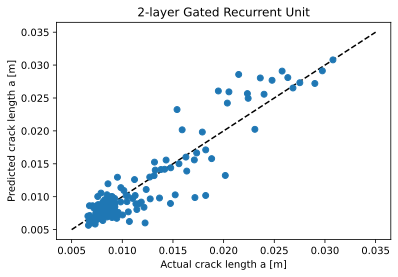

In [12]:
plt.plot([0.005, 0.035], [0.005, 0.035], '--k')
plt.plot(a[:,-1:].squeeze(-1), preds, 'o')
plt.title("2-layer Gated Recurrent Unit")
plt.ylabel('Predicted crack length a [m]')
plt.xlabel('Actual crack length a [m]')

In [13]:
print("Mean squared error:", np.mean((preds-a[:,-1:].squeeze(-1))**2))

Mean squared error: 2.870194832870724e-06


## Physics-informed model
Now, we inject the physics-based knowledge we have of the fatigue crack propagation. More specifically, we make use of the Paris crack law. To simulate that we do not have a complete physics-based model of our problem, we assume that relationship between the sensor measurements $\Delta S$ and the stress-intensity range $\Delta K$ is unknown.

Here, we use a slightly different approach to the one used by the [paper authors](https://github.com/PML-UCF/pinn/tree/master/samples/cumulative_damage/airplane_fleet_crack_growth). Instead of processing one time-step at a time recursively, we increase the input window to include several time steps (10, for example). This slightly breaks the strict adherence to the Paris law but also gives a shorter for-loop.

For each step, the $\Delta S$ (length=number of timesteps) and current crack length estimate $a_t$ is concatenated and embedded via an MLP (Encoder module below) to a latent space of size [batch_size,1]. This is then passed through a sigmoid and then scaled up to represent the stress-intensity range $\Delta K$. This estimate is then in turn used in the Paris law layer to get the crack length increment $\Delta a_t$. The input to the next timestep is then simply $a_t = a_{t-w} + \Delta a_t$, where $w$ is the sequence length.

In [14]:
# New DataLoaders because we do not min-max scale the labels for the physics-informed model

X = torch.from_numpy(S_train).to(device)
y = torch.from_numpy(a_train).to(device)

# Train DataLoader
train_loader = data_utils.DataLoader(data_utils.TensorDataset(X, y),
                                     batch_size=batch_size, shuffle=True)

# Test DataLoader
X_test = torch.from_numpy(S).to(device)
y_test = torch.from_numpy(a).to(device)

test_loader = data_utils.DataLoader(data_utils.TensorDataset(X_test, y_test),
                                     batch_size=batch_size, shuffle=False)

In [15]:
class ParisLaw(nn.Module):
    def __init__(self, C, m):
        super().__init__()
        self.m = nn.Parameter(torch.tensor([m]),requires_grad=False)
        self.C = nn.Parameter(torch.tensor([C]),requires_grad=False)

    def forward(self,K):
        x = torch.mul(self.C, torch.pow(K,self.m))
        return x

class Encoder(nn.Module):
    def __init__(self, seq_len, hidden_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_len+1,hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim,1),
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)
                torch.nn.init.zeros_(m.bias)

    def forward(self,x):
        x = self.encoder(x)
        return x

class ScalingLayer(nn.Module):
    def __init__(self, scale, bias):
        super().__init__()
        self.scaling = nn.Linear(1,1)
        nn.init.constant_(self.scaling.weight, scale)
        nn.init.constant_(self.scaling.bias, bias)

    def forward(self,x):
        return self.scaling(x)

class ParisPINN(nn.Module):
    def __init__(self, batch_size, C, m, a0, seq_len, hidden_dim, scale, bias):
        """
        Args:
            batch_size (int): batch size
            C (int): Paris law material constant
            m (int): Paris law exponent
            a0 (int): initial crack length
            seq_len (int): sequence length
            hidden_dim (int): number of neurons in the encoder MLPs
            scale (int): weight init for the scaling layer
            bias (int): bias init for the scaling layer
        """
        super().__init__()
        self.a0 = nn.Parameter(torch.ones(batch_size,1) * \
                               torch.tensor([a0]),requires_grad=False)
        self.C = C
        self.m = m
        self.seq_len = seq_len
        self.encoder = Encoder(seq_len, hidden_dim)
        self.scaling = ScalingLayer(scale, bias)
        self.a_scaling = ScalingLayer(30., 0)
        self.parislaw = ParisLaw(C, m)
        self.act = nn.Sigmoid()
    
    def forward(self,S):
        a = []
        a_t = self.a0

        for t in range(S.size(1)//self.seq_len):
            x = S[:,t*self.seq_len:(t+1)*self.seq_len,:].squeeze(-1)
            x = torch.cat((x, self.a_scaling(a_t)), 1)
            x = self.encoder(x)
            x = self.act(x)
            x = self.scaling(x)
            x = self.parislaw(x)
            a_t = a_t + x
            a.append(a_t)

        return torch.stack(a)

In [16]:
lr = 1e-3
seq_len = 10      # Sequence length (n timesteps)
hidden_dim = 32   # Size of hidden dim in encoder MLP
scale = 50.       # Scales the stress-intensity estimate
bias = 10.        # Bias added to stress-intensity estimate

model = ParisPINN(batch_size, C, m, a0, seq_len, hidden_dim, scale, bias).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [17]:
# Training loop
n_epochs = 500
loss_fn = nn.MSELoss()
model.train()

loop = tqdm(range(n_epochs),leave=False)
for epoch in loop:
    epoch_loss = 0.
    for batch in train_loader:
        
        # Get inputs and targets
        inputs, targets = batch
        inputs = inputs.type(torch.cuda.FloatTensor)
        targets = targets.type(torch.cuda.FloatTensor)

        # Set optimizer grads to zero
        optimizer.zero_grad()

        # Get outpute of model
        output = model(inputs)
        output = output.permute(1,0,2).squeeze(-1)

        # Slice.
        output = output[:,-1:]
        targets = targets[:,-1:]
        
        # Calculate loss
        loss = loss_fn(output,targets)
        epoch_loss += loss.item()

        # Backprop & step optimizer
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f"Epoch [{epoch} / {n_epochs}]")
        loop.set_postfix(loss = loss.item())

    #print(epoch, epoch_loss / len(train_loader))

print('training done')
print(f"Final epoch loss: {loss.item()}")

  0%|          | 0/500 [00:00<?, ?it/s]

training done
Final epoch loss: 1.0090602842183216e-07


In [18]:
model.eval()

preds = []

for test_batch in tqdm(test_loader):
    
    # Get inputs and targets
    inputs, targets = test_batch
    inputs = inputs.type(torch.cuda.FloatTensor)
    targets = targets.type(torch.cuda.FloatTensor)

    # Get outpute of model
    predictions = model(inputs)
    predictions = predictions[-1:,:,:].squeeze(0)

    predictions = predictions.detach().cpu().numpy()
    preds.append(predictions)

preds = np.concatenate(preds,0)

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 0, 'Actual crack length a [m]')

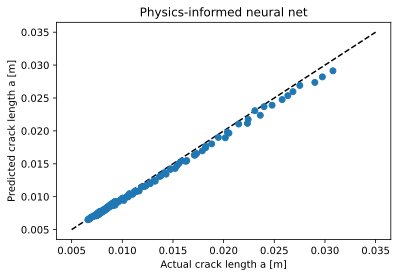

In [19]:
plt.plot([0.005, 0.035], [0.005, 0.035], '--k')
plt.plot(a[:,-1:].squeeze(-1),preds.squeeze(-1),'o')
plt.title("Physics-informed neural net")
plt.ylabel('Predicted crack length a [m]')
plt.xlabel('Actual crack length a [m]')

In [20]:
print(np.mean((preds.squeeze(-1)-a[:,-1:].squeeze(-1))**2))

1.65238564893582e-07
